In [1]:
# Import all necessary libraries and utility functions
import math
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
# Import dataset to be used for training and testing
AAPL = pd.read_csv("./Database/Pre_Processed_AAPL.csv")
AMZN = pd.read_csv("./Database/Pre_Processed_AMZN.csv")
GOOG = pd.read_csv("./Database/Pre_Processed_GOOG.csv")
MSFT = pd.read_csv("./Database/Pre_Processed_MSFT.csv")
TSLA = pd.read_csv("./Database/Pre_Processed_TSLA.csv")

### Data Preprocessing

In [3]:
# Shape the data to for use with LightGBM
def prep_data(data, split_date):
    data['Date'] = pd.to_datetime(data['Date'])

    
    ######################## Feature engineering using Stock Market Indicators ######################## 
    # Introduce lag featues into the dataset (90 days lag)
    lag_features = {f'lag_{lag}': data['Adj. Close'].shift(lag) for lag in range(1, 91)}

    # Moving Average Convergence/Divergence (MACD) feature
    def ema(series, span):
        return series.ewm(span=span, adjust=False).mean()
    
    ema_fast = ema(data['Adj. Close'], 12)
    ema_slow = ema(data['Adj. Close'], 26)
    macd = ema_fast - ema_slow
    macd_signal = ema(macd, 9)
    macd_features = {
        'ema_fast': ema_fast,
        'ema_slow': ema_slow,
        'macd': macd,
        'macd_signal': macd_signal,
        'macd_diff': macd - macd_signal
    }
        

    # Moving Averages (MA) feature
    ma_features = {f'ma_{window}': data['Adj. Close'].rolling(window=window).mean() 
                   for window in [30, 60, 90, 120, 150, 180, 210]}

    # Relative Strenght Index (RSI) feature
    delta = data['Adj. Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    window = 14
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    rsi_features = {'rsi': rsi}
    
    # Stochastic Oscillator (Stoch) features
    lowest_low = data['Low'].rolling(window=14).min()
    highest_high = data['High'].rolling(window=14).max()
    stoch_k = ((data['Adj. Close'] - lowest_low) / (highest_high - lowest_low)) * 100
    stoch_d = stoch_k.rolling(3).mean()
    stoch_features = {'stoch_k': stoch_k, 'stoch_d': stoch_d}

    # MESA Sine Wave features
    mesa_sine_wave = np.sin(data['Adj. Close'].pct_change().cumsum())
    mesa_features = {'mesa_sine_wave': mesa_sine_wave}
    
    ################################################################################################  

    # All market indicators features object
    all_features = {
        **lag_features,
        **macd_features,
        **ma_features,
        **rsi_features,
        **stoch_features,
        **mesa_features,
    }

    # Concatenate all features into the original DataFrame
    data = pd.concat([data, pd.DataFrame(all_features)], axis=1)

    # Drop rows with NaN values introduced from feature engineering
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(inplace=True)

    train_data = data[data['Date'] < split_date]
    test_data = data[data['Date'] >= split_date]

    features = [col for col in data.columns if col not in ['Date', 'Adj. Close', 'target']]
    target = 'Adj. Close'

    X_train, y_train = train_data[features], train_data[target]
    X_test, y_test = test_data[features], test_data[target]

    return X_train, y_train, X_test, y_test

### LightGBM Model

In [4]:
# Function to train and test LightGBM model 
def lightgbm_model(X_train, y_train, X_test, y_test):
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    params = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "learning_rate": 0.01,
        "num_leaves": 200,
        "max_depth": -1,
        "feature_fraction": 1.0,
        "bagging_fraction": 1.0,
        "bagging_freq": 5,
        "lambda_l1": 0.001,
        "lambda_l2": 0.001,
        "verbose": -1
    }

    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, test_data],
        num_boost_round=150000,
        callbacks=[lgb.early_stopping(stopping_rounds=200)]
    )

    predictions = model.predict(X_test, num_iteration=model.best_iteration)

    return model, predictions

# Apple

### Model Fitting & Prediction

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1220]	training's rmse: 0.244783	valid_1's rmse: 9.58897
Shape of Prediction:  (102,)
RMSE: 9.588972846031774
MAPE: 0.054975284234172694


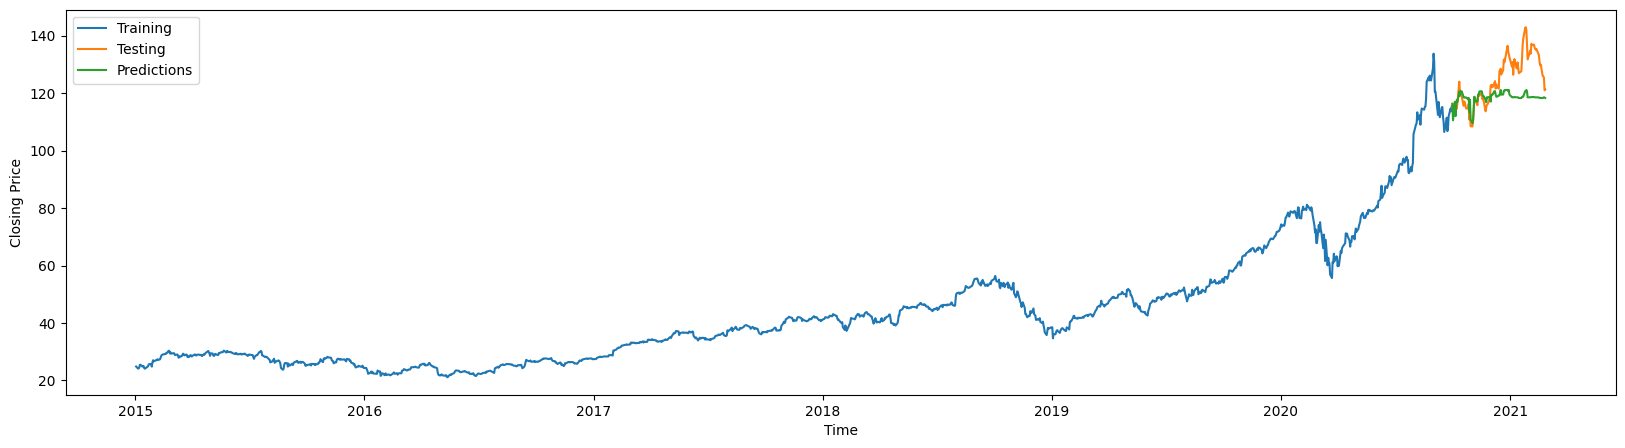

In [5]:
# Date seperation for training, testing and predicitions
split_date = "2020-10-01"

# Training and testing data preparation
aapl_x_train, aapl_y_train, aapl_x_test, aapl_y_test = prep_data(AAPL, split_date)

# Model training
lgb_aapl_model, lgb_aapl_pred = lightgbm_model(aapl_x_train, aapl_y_train, aapl_x_test, aapl_y_test)
AAPL_prediction = lgb_aapl_pred
print("Shape of Prediction: ",AAPL_prediction.shape)

# Model performance metrics
rmse = math.sqrt(mean_squared_error(aapl_y_test, lgb_aapl_pred))
mape = mean_absolute_percentage_error(aapl_y_test, lgb_aapl_pred)

# Print results of performance metrics for comparison with authors regression models
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

# Plot similar stock market prediction graph to the research paper for comparison
plt.figure(figsize=(20, 5))
plt.plot(AAPL['Date'][AAPL['Date'] < split_date], AAPL['Adj. Close'][AAPL['Date'] < split_date], label = 'Training')
plt.plot(AAPL['Date'][AAPL['Date'] >= split_date], AAPL['Adj. Close'][AAPL['Date'] >= split_date], label = 'Testing')
plt.plot(AAPL['Date'][AAPL['Date'] >= split_date], AAPL_prediction, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

# Tesla

### Model Fitting & Prediction

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[14387]	training's rmse: 0.0232035	valid_1's rmse: 228.649
RMSE: 228.64852622700056
MAPE: 0.2263488342597978


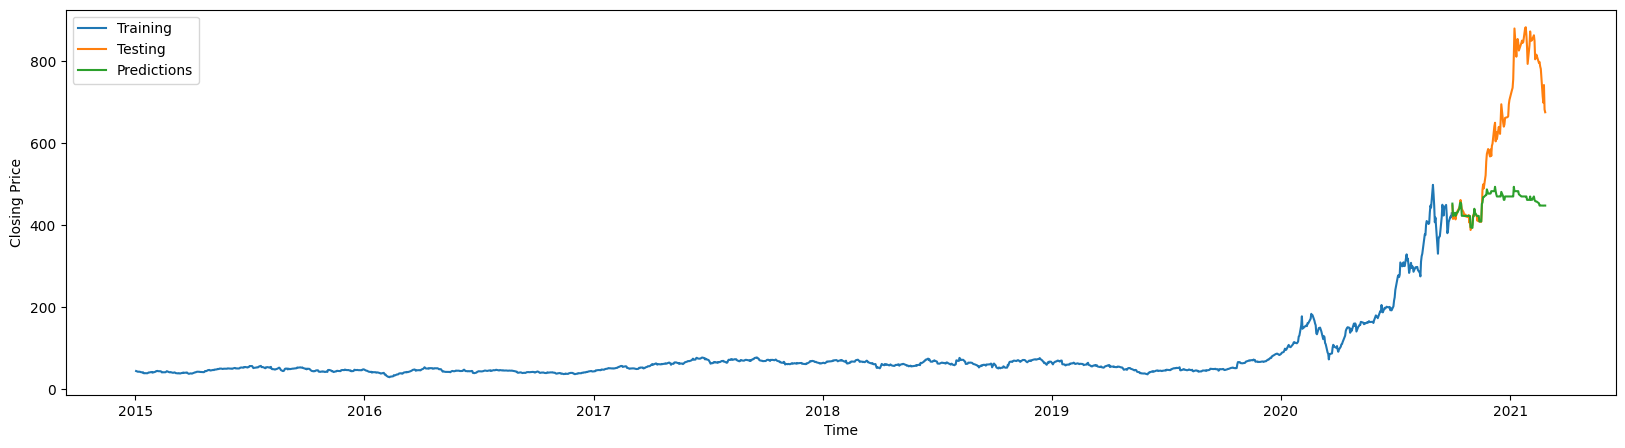

In [6]:
# Training and testing data preparation
tsla_x_train, tsla_y_train, tsla_x_test, tsla_y_test = prep_data(TSLA, split_date)

# Model training
lgb_tsla_model, lgb_tsla_pred = lightgbm_model(tsla_x_train, tsla_y_train, tsla_x_test, tsla_y_test)
TSLA_prediction = lgb_tsla_pred

# Model performance metrics
rmse = math.sqrt(mean_squared_error(tsla_y_test, lgb_tsla_pred))
mape = mean_absolute_percentage_error(tsla_y_test, lgb_tsla_pred)

# Print results of performance metrics for comparison with authors regression models
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

# Plot similar stock market prediction graph to the research paper for comparison
plt.figure(figsize=(20, 5))
plt.plot(TSLA['Date'][TSLA['Date'] < split_date], TSLA['Adj. Close'][TSLA['Date'] < split_date], label = 'Training')
plt.plot(TSLA['Date'][TSLA['Date'] >= split_date], TSLA['Adj. Close'][TSLA['Date'] >= split_date], label = 'Testing')
plt.plot(TSLA['Date'][TSLA['Date'] >= split_date], TSLA_prediction, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

# Google

### Model Fitting & Prediction

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[47561]	training's rmse: 6.10182e-05	valid_1's rmse: 198.65
RMSE: 198.6497338965062
MAPE: 0.0836278123484485


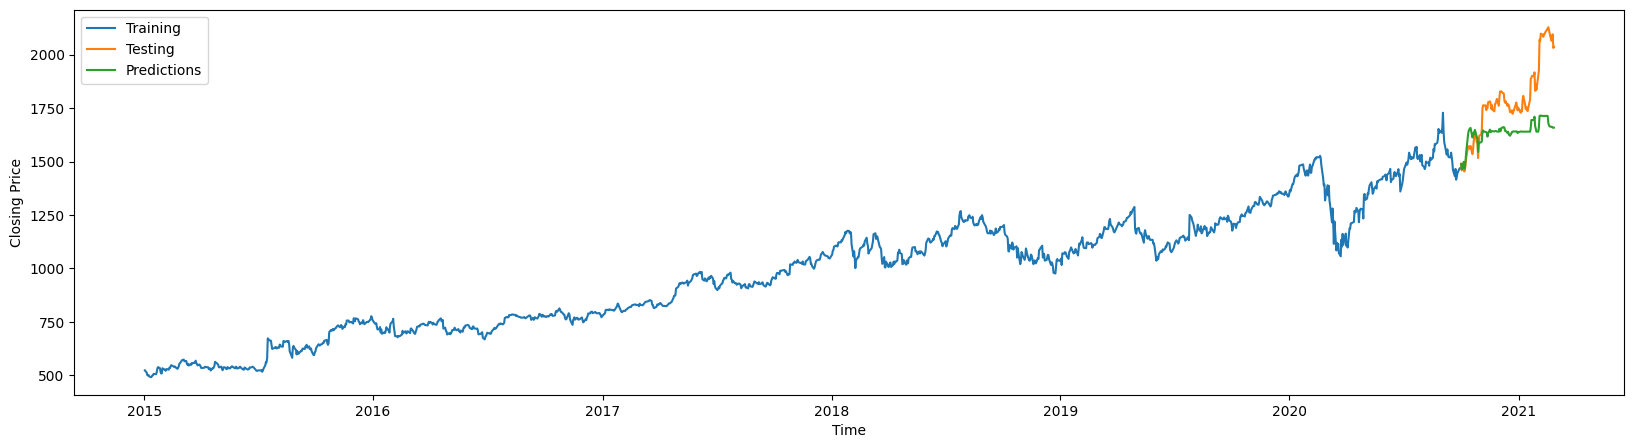

In [7]:
# Training and testing data preparation
goog_x_train, goog_y_train, goog_x_test, goog_y_test = prep_data(GOOG, split_date)

# Model training
lgb_goog_model, lgb_goog_pred = lightgbm_model(goog_x_train, goog_y_train, goog_x_test, goog_y_test)
GOOG_prediction = lgb_goog_pred

# Model performance metrics
rmse = math.sqrt(mean_squared_error(goog_y_test, lgb_goog_pred))
mape = mean_absolute_percentage_error(goog_y_test, lgb_goog_pred)

# Print results of performance metrics for comparison with authors regression models
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

# Plot similar stock market prediction graph to the research paper for comparison
plt.figure(figsize=(20, 5))
plt.plot(GOOG['Date'][GOOG['Date'] < split_date], GOOG['Adj. Close'][GOOG['Date'] < split_date], label = 'Training')
plt.plot(GOOG['Date'][GOOG['Date'] >= split_date], GOOG['Adj. Close'][GOOG['Date'] >= split_date], label = 'Testing')
plt.plot(GOOG['Date'][GOOG['Date'] >= split_date], GOOG_prediction, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

# Microsoft

### Model Fitting & Prediction

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[33291]	training's rmse: 7.18957e-05	valid_1's rmse: 8.91513
RMSE: 8.91512996687707
MAPE: 0.028002530021250197


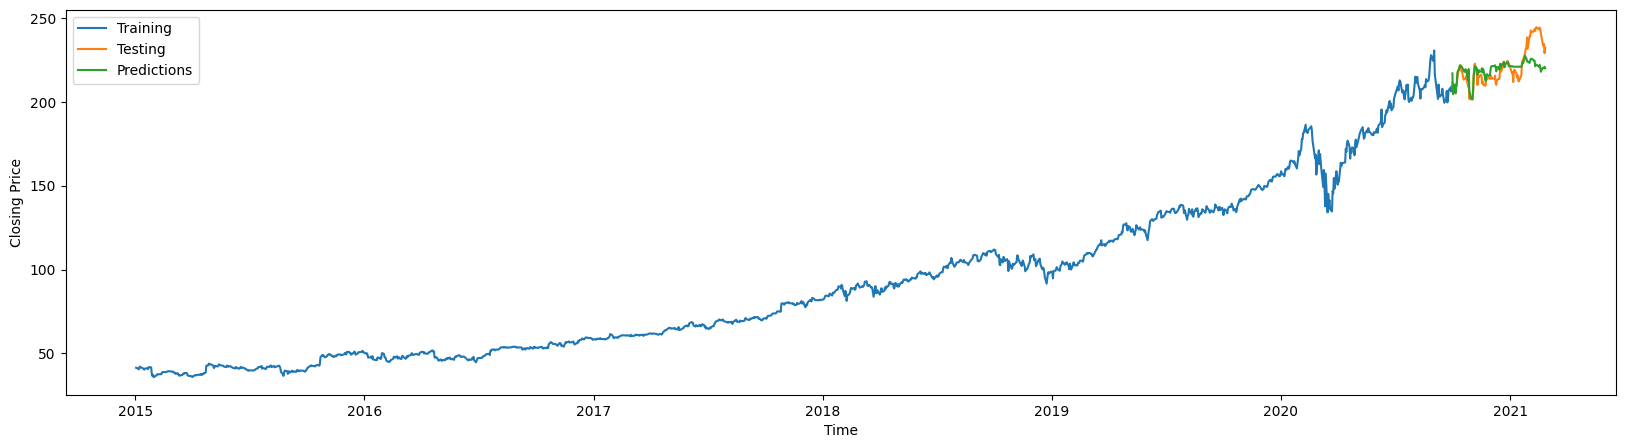

In [8]:
# Training and testing data preparation
msft_x_train, msft_y_train, msft_x_test, msft_y_test = prep_data(MSFT, split_date)

# Training and testing data preparation
lgb_msft_model, lgb_msft_pred = lightgbm_model(msft_x_train, msft_y_train, msft_x_test, msft_y_test)
MSFT_prediction = lgb_msft_pred

# Model performance metrics
rmse = math.sqrt(mean_squared_error(msft_y_test, lgb_msft_pred))
mape = mean_absolute_percentage_error(msft_y_test, lgb_msft_pred)

# Print results of performance metrics for comparison with authors regression models
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

# Plot similar stock market prediction graph to the research paper for comparison
plt.figure(figsize=(20, 5))
plt.plot(MSFT['Date'][MSFT['Date'] < split_date], MSFT['Adj. Close'][MSFT['Date'] < split_date], label = 'Training')
plt.plot(MSFT['Date'][MSFT['Date'] >= split_date], MSFT['Adj. Close'][MSFT['Date'] >= split_date], label = 'Testing')
plt.plot(MSFT['Date'][MSFT['Date'] >= split_date], MSFT_prediction, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

# Amazon

### Model Fitting & Prediction

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[358]	training's rmse: 20.4278	valid_1's rmse: 43.3833
RMSE: 43.38327614667526
MAPE: 0.01036916788801089


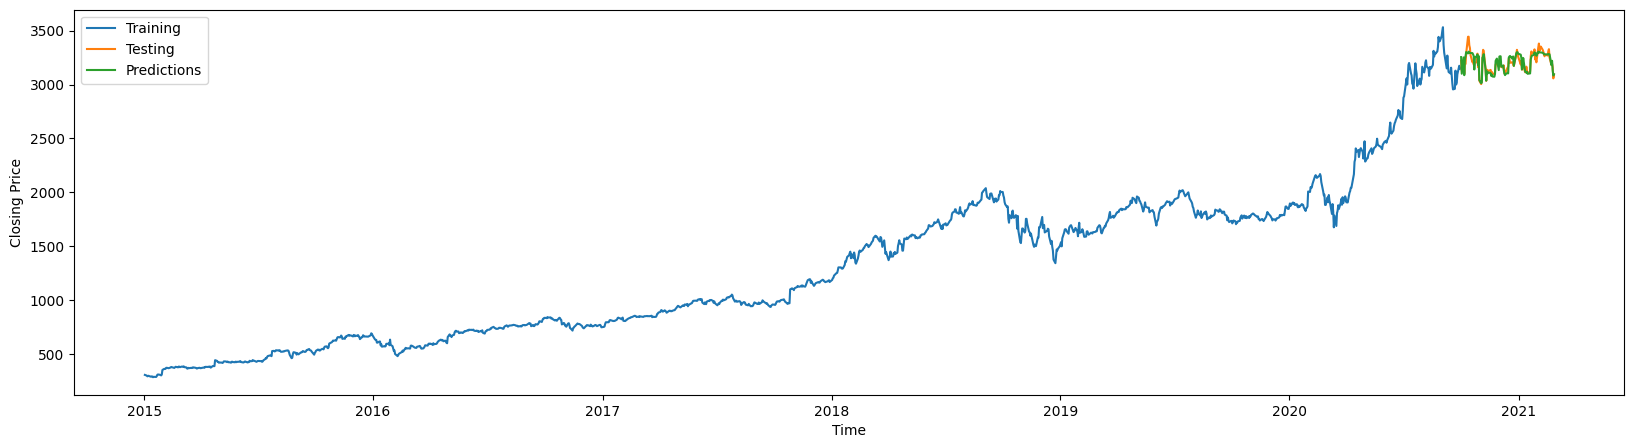

In [10]:
# Training and testing data preparation
amzn_x_train, amzn_y_train, amzn_x_test, amzn_y_test = prep_data(AMZN, split_date)

# Model training
lgb_amzn_model, lgb_amzn_pred = lightgbm_model(amzn_x_train, amzn_y_train, amzn_x_test, amzn_y_test)
AMZN_prediction = lgb_amzn_pred

# Model performance metrics
rmse = math.sqrt(mean_squared_error(amzn_y_test, lgb_amzn_pred))
mape = mean_absolute_percentage_error(amzn_y_test, lgb_amzn_pred)

# Print results of performance metrics for comparison with authors regression models
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

# Plot similar stock market prediction graph to the research paper for comparison
plt.figure(figsize=(20, 5))
plt.plot(AMZN['Date'][AMZN['Date'] < split_date], AMZN['Adj. Close'][AMZN['Date'] < split_date], label = 'Training')
plt.plot(AMZN['Date'][AMZN['Date'] >= split_date], AMZN['Adj. Close'][AMZN['Date'] >= split_date], label = 'Testing')
plt.plot(AMZN['Date'][AMZN['Date'] >= split_date], AMZN_prediction, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')